# Special Session: Noise Characterization and Error Mitigation in Near-Term Quanutm Computers

* Christopher J. Wood (cjwood@us.ibm.com)
* IBM Quantum, T. J. Watson Research Center, Yorktown Heights, USA

This notebook contains the accompanying code to the ICCD 2020 special session proceeding *Noise Characterization and Error Mitigation in Near-Term Quantum Computers*.

## 4.Measurement Error Mitigation

This notebook demonstrates performing measurement error mitigation on stabilizer graph state fidelity estimates on a 4-qubit subset of an IBM Quantum device using the continous-time Markov Process (CTPM) error mitigation technique.

In [1]:
# Qiskit Module
import qiskit
import qiskit.quantum_info as qi
import qiskit.ignis.mitigation as mit

# Noisy Simulation
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.utils import insert_noise

# File utilities for saving and loading JSON data
from file_utils import save_to_json, load_properties, load_result

# Other
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Helper functions

The following helper functions are used to generate stabilzier measurement circuits and compute expectation values from result data.

In [2]:
def compute_stabilizer_group(circuit):
    """Compute the stabilizer group for stabilizer circuit."""
    state = qi.Statevector.from_instruction(circuit)
    labels = []
    for i in qi.pauli_basis(state.num_qubits):
        val = round(qi.state_fidelity(i.to_matrix()[0], state, validate=False))
        if val != 0:
            label = i.to_labels()[0]
            if val == 1:
                label = '+' + label
            else:
                label = '-' + label
            labels.append(label)
    return labels

def stabilizer_coeff_pauli(stabilizer):
    """Return the 1 or -1 coeff and Pauli label."""
    coeff = 1
    pauli = coeff
    if stabilizer[0] == '-':
        coeff = -1
    if stabilizer[0] in ['+', '-']:
        pauli = stabilizer[1:]
    else:
        pauli = stabilizer
    return coeff, pauli

def stabilizer_measure_circuit(stabilizer, initial_circuit=None):
    """Return a stabilizer measurement cirucits.
    
    Args:
        stabilizer (str): a stabilizer string
        initial_circuit (QuantumCircuit): Optional, the initial circuit.
    
    Returns:
        QuantumCircuit: the circuit with stabilizer measurements.
    """
    _, pauli = stabilizer_coeff_pauli(stabilizer)
    if initial_circuit is None:
        circ = qiskit.QuantumCircuit(len(pauli))
    else:
        circ = initial_circuit.copy()
    for i, s in enumerate(reversed(pauli)):
        if s == 'X':
            circ.h(i)
        if s == 'Y':
            circ.sdg(i)
            circ.h(i)
    circ.measure_all()
    return circ


def stabilizer_measure_diagonal(stabilizer):
    """Return the diagonal vector for a stabilizer measurement.
    
    Args:
        stabilizer (str): a stabilizer string
    
    Returns:
        np.ndarray: the diagonal for measurement in the stabilizer basis.
    """
    coeff, pauli = stabilizer_coeff_pauli(stabilizer)
    diag = np.array([1])
    for s in reversed(pauli):
        if s == 'I':
            tmp = np.array([1, 1])
        else:
            tmp = np.array([1, -1])
        diag = np.kron(tmp, diag)
    return coeff * diag


def stabilizer_expvals(result, stabilizers, meas_mitigator=None):
    """Compute expectation values from stabilizer measurement results."""
    expvals = []
    stddevs = []
    for i, stab in enumerate(stabilizers):
        expval, stddev = mit.expectation_value(
            result.get_counts(i),
            diagonal=stabilizer_measure_diagonal(stab),
            meas_mitigator=meas_mitigator)
        expvals.append(expval)
        stddevs.append(stddev)
    return np.array(expvals), np.array(stddevs)

    
def stabilizer_fidelity(expvals, stddevs=None):
    """Compute stabilizer state fidelity from stabilizer expvals."""
    mean = np.mean(expvals)
    if stddevs is None:
        return mean
    stddev = np.sqrt(np.sum(stddevs ** 2))
    return mean, stddev

## Graph State Circuit

We will estimate the state fidelity of preparing an entangled 4-qubit graph state by computing the expectation values of the graph state stabilizers. First we prepare a 4-qubit graph state quantum circuit

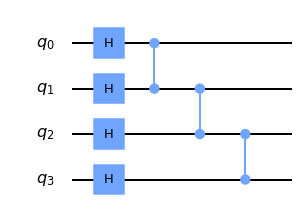

In [3]:
num_qubits = 4
adjmat = [[0, 1, 0, 0], [1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0]]
state_circuit = qiskit.circuit.library.GraphState(adjmat)
state_circuit.draw('mpl')

### Stabilizer Measurement Circuits

Next we compute the set of stabilizers generators for the graph state using the `Clifford` class from the `quantum_info` module. We compute the full group by brute force.

In [4]:
generators = qi.Clifford(state_circuit).stabilizer.pauli.to_labels()
stabilizers = compute_stabilizer_group(state_circuit)
print('Stabilizers:', stabilizers)
print('Generators:', generators)
generator_index = [1, 2, 13, 6]

Stabilizers: ['+IIII', '+IIZX', '+IZXZ', '+IZYY', '+XIXZ', '+XIYY', '+XZII', '+XZZX', '+YXXY', '-YXYZ', '+YYIX', '+YYZI', '+ZXIX', '+ZXZI', '-ZYXY', '+ZYYZ']
Generators: ['IIZX', 'IZXZ', 'ZXZI', 'XZII']


In [5]:
stabilizer_circuits = [stabilizer_measure_circuit(stab, state_circuit)
                       for stab in stabilizers]

### Measurement Error Characterization Circuits

We also need to run the measurement error characterization circuits as outlined in the previous notebook.

In [6]:
labels = ['0000', '0011', '0101', '1001', '0110', '1010', '1100', '1111']
meas_cal_circuits, metadata = mit.expval_meas_mitigator_circuits(4, labels=labels)

### Run Experiment

Next execute the circuits on an IBM Quantum backend. You may change this to run on any IBM Quantum backend you have access to.

In [7]:
use_saved_data = True
file_properties = 'data/properties_stab_v1.json'
file_result = 'data/result_stab_v1.json'
file_result_mit = 'data/result_stab_mit_v1.json'

if use_saved_data:

    # Load saved result data from file
    result_backend = load_result(file_result)
    result_mit_backend = load_result(file_result_mit)

    # Load saved properties from file
    properties = load_properties(file_properties)

else:

    # Load IBMQ Account data
    from qiskit import IBMQ
    IBMQ.load_account()

    # Get backend for experiment
    provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed')
    backend = provider.get_backend('ibmq_montreal')

    # Run QPT on backend
    shots = 8192
    job_mit_backend = qiskit.execute(meas_cal_circuits, backend, shots=shots)
    job_backend = qiskit.execute(stabilizer_circuits, backend, shots=shots)
    print('Job IDs: {}'.format([job_mit_backend.job_id(), job_backend.job_id()]))

    # Save a copy of the backend properties to file
    properties = backend.properties()
    save_to_json(properties, file_properties)

    # Retrieve results (this may take a while depending on the queue)
    result_mit_backend = job_mit_backend.result()
    result_backend = job_backend.result()
    
    # Save a copy of the result data to file
    save_to_json(result_backend, file_result)    
    save_to_json(result_mit_backend, file_result_mit)    

### Run Simulation

Next we run the characterization experiment using the Qiskit Aer simulator with the basic device noise model based on the backend used to run the experiment

In [8]:
# Simulator backend
simulator = QasmSimulator()
shots = 8192
seed_simulator = 1984

# Noise Model
noise_model = NoiseModel.from_backend(properties, warnings=False)

# Run simulation
result_sim = qiskit.execute(stabilizer_circuits,
                            simulator,
                            shots=shots,
                            seed_simulator=seed_simulator,
                            basis_gates=noise_model.basis_gates,
                            noise_model=noise_model).result()

result_mit_sim = qiskit.execute(meas_cal_circuits,
                                simulator,
                                shots=shots,
                                seed_simulator=seed_simulator,
                                basis_gates=noise_model.basis_gates,
                                noise_model=noise_model).result()

## Measurement Error Mitigated Expectation Values

Next we use our helper functions to compute the exectation values for each stabilzier measurement with and without using the measurement error mitigator. This makes use of the `expectation_value` function from the `mitigation` module.

In [9]:
# Fit measurement error mitigators
mitigator_backend = mit.ExpvalMeasMitigatorFitter(result_mit_backend, metadata).fit()
mitigator_sim = mit.ExpvalMeasMitigatorFitter(result_mit_sim, metadata).fit()

# Unmitigated Expectation Values
expvals_nomit_b, stddevs_nomit_b = stabilizer_expvals(
    result_backend, stabilizers)
expvals_nomit_s, stddevs_nomit_s = stabilizer_expvals(
    result_sim, stabilizers)

# Measurement error mitigated expectation values
expvals_mit_b, stddevs_mit_b = stabilizer_expvals(
    result_backend, stabilizers, meas_mitigator=mitigator_backend)
expvals_mit_s, stddevs_mit_s = stabilizer_expvals(
    result_sim, stabilizers, meas_mitigator=mitigator_sim)

### Stabilizer Expectation Value Plot

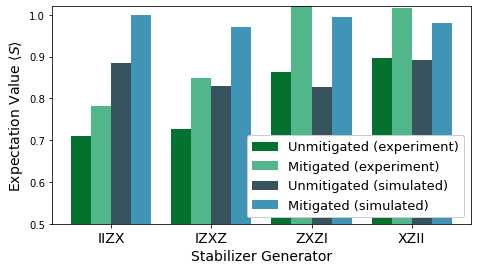

In [10]:
vals_nomit_b = [expvals_nomit_b[i] for i in generator_index]
vals_mit_b = [expvals_mit_b[i] for i in generator_index]
vals_nomit_s = [expvals_nomit_s[i] for i in generator_index]
vals_mit_s = [expvals_mit_s[i] for i in generator_index]

colors1 = sns.color_palette("BuGn_r")
colors2 = sns.color_palette("GnBu_d")
labels = generators
x = np.arange(len(labels))
width = 0.2

label_nomit_b = 'Unmitigated (experiment)'
label_mit_b = 'Mitigated (experiment)'
label_nomit_s = 'Unmitigated (simulated)'
label_mit_s = 'Mitigated (simulated)'

fig, ax = plt.subplots(figsize=(7.5, 4))
ax.bar(x - 3 * width / 2, vals_nomit_b, width, label=label_nomit_b, color=colors1[0])
ax.bar(x - width / 2, vals_mit_b, width, label=label_mit_b, color=colors1[2])
ax.bar(x + width / 2, vals_nomit_s, width, label=label_nomit_s, color=colors2[0])
ax.bar(x + 3 * width / 2, vals_mit_s, width, label=label_mit_s, color=colors2[2])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(r'Expectation Value $\langle S\rangle$', fontsize=14)
ax.set_xlabel('Stabilizer Generator', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=14)
ax.set_ylim(0.5, 1.02)
ax.legend(loc='lower right', fontsize=13, framealpha=1)
fig.savefig('figures/expval_mit.png', dpi=150)

## Measurement Error Mitigated State Fidelity

Finally we can use the mitigated expectation values to estimate the error mitigated state fidelity of the prepared graph state

In [11]:
F_nomit_backend = stabilizer_fidelity(expvals_nomit_b, stddevs_nomit_b)
F_nomit_sim = stabilizer_fidelity(expvals_nomit_s, stddevs_nomit_s)
F_mit_backend = stabilizer_fidelity(expvals_mit_b, stddevs_mit_b)
F_mit_sim = stabilizer_fidelity(expvals_mit_s, stddevs_mit_s)

print('Graph-state fidelity estimates')
print('\nNo mitigation')
print('F({}) = {:.3f} \u00B1 {:.3f}'.format(
    properties.backend_name, F_nomit_backend[0], F_nomit_backend[1]))
print('F(simulated) = {:.3f} \u00B1 {:.3f}'.format(
    F_nomit_sim[0], F_nomit_sim[1]))

print('\nCTMP error mitigation')
print('F({}) = {:.3f} \u00B1 {:.3f}'.format(
    properties.backend_name, F_mit_backend[0], F_mit_backend[1]))
print('F(simulated) = {:.3f} \u00B1 {:.3f}'.format(
    F_mit_sim[0], F_mit_sim[1]))

Graph-state fidelity estimates

No mitigation
F(ibmq_boeblingen) = 0.727 ± 0.030
F(simulated) = 0.838 ± 0.024

CTMP error mitigation
F(ibmq_boeblingen) = 0.838 ± 0.060
F(simulated) = 0.976 ± 0.062


### Exact state fidelity for simulated case

For the simualted case we can compare the mitigated fidelity estimate to the exact value computed from the device noise model without measurement error

In [12]:
state_circuit_noise = insert_noise(state_circuit, noise_model, transpile=True)
ideal_state = qi.Statevector.from_instruction(state_circuit)
noisy_state = qi.DensityMatrix.from_instruction(state_circuit_noise)
F_exact_sim = qi.state_fidelity(noisy_state, ideal_state)

print('Exact State Fidelity')
print('F(simulated) = {:.3f}'.format(F_exact_sim))

Exact State Fidelity
F(simulated) = 0.972


In [13]:
import qiskit.tools.jupyter
%qiskit_version_table